# Module 2: Predictive Modeling for Fraud Detection

This notebook performs data cleaning, feature engineering, exploratory data analysis with plots, saves the processed dataset, trains multiple machine learning models to predict transaction fraud, compares their performance using precision, recall, F1-score, and ROC-AUC, generates comparison plots, and saves the trained models.

The target variable is 'isFraud', and we treat this as a binary classification problem.

To achieve the best possible performance, we have added hyperparameter tuning using RandomizedSearchCV for each model.

In [ ]:
!pip install pandas numpy scikit-learn matplotlib seaborn xgboost lightgbm joblib

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from pathlib import Path

## Load the Dataset

In [2]:
DATA_PATH = Path("c:/Users/ghosh/Desktop/Predictive Transaction Intelligence using for BFSI/Dataset/card_fraud.csv")

df = pd.read_csv(DATA_PATH)

# Drop unnecessary columns (assuming 'index' is not needed; adjust if IDs are useful for aggregation)
df.drop(['index'], axis=1, inplace=True, errors='ignore')

# Display the first few rows
df.head()

,Transaction_ID,User_ID,Transaction_Amount,Transaction_Date,Transaction_Time,Transaction_Location,Merchant_ID,Device_ID,Card_Type,Transaction_Currency,Transaction_Status,Previous_Transaction_Count,Distance_Between_Transactions_km,Time_Since_Last_Transaction_min,Authentication_Method,Transaction_Velocity,Transaction_Category,isFraud
0,1001,68389745,69635000,1/1/2024 0:00,0:00:00,Surkhandarya,6710,2060,UzCard,UZS,Successful,35,3481.19,30,2FA,5,Transfer,1
1,1002,42122340,53486000,1/1/2024 0:01,0:01:00,Namangan,6498,2797,UzCard,USD,Successful,35,4341.04,1073,Biometric,9,Cash Out,1
2,1003,87539955,24262000,1/1/2024 0:02,0:02:00,Navoiy,5039,2519,Humo,UZS,Reversed,25,4780.35,132,2FA,7,Cash In,1
3,1004,98657863,56019000,1/1/2024 0:03,0:03:00,Bukhara,6115,2641,Humo,UZS,Failed,44,719.43,41,Biometric,1,Payment,1
4,1005,88084360,87823000,1/1/2024 0:04,0:04:00,Andijan,5072,2923,Humo,UZS,Failed,21,4691.06,458,Password,8,Cash Out,1


## Exploratory Data Analysis

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 18 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   Transaction_ID                    100000 non-null  int64  
 1   User_ID                           100000 non-null  int64  
 2   Transaction_Amount                100000 non-null  int64  
 3   Transaction_Date                  100000 non-null  object 
 4   Transaction_Time                  100000 non-null  object 
 5   Transaction_Location              100000 non-null  object 
 6   Merchant_ID                       100000 non-null  int64  
 7   Device_ID                         100000 non-null  int64  
 8   Card_Type                         100000 non-null  object 
 9   Transaction_Currency              100000 non-null  object 
 10  Transaction_Status                100000 non-null  object 
 11  Previous_Transaction_Count        100000 non-null  in

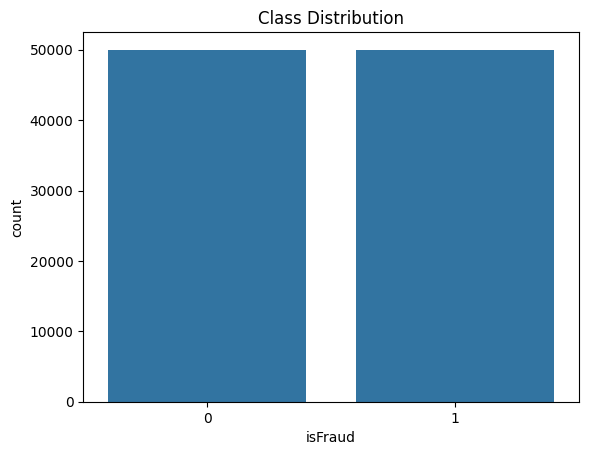

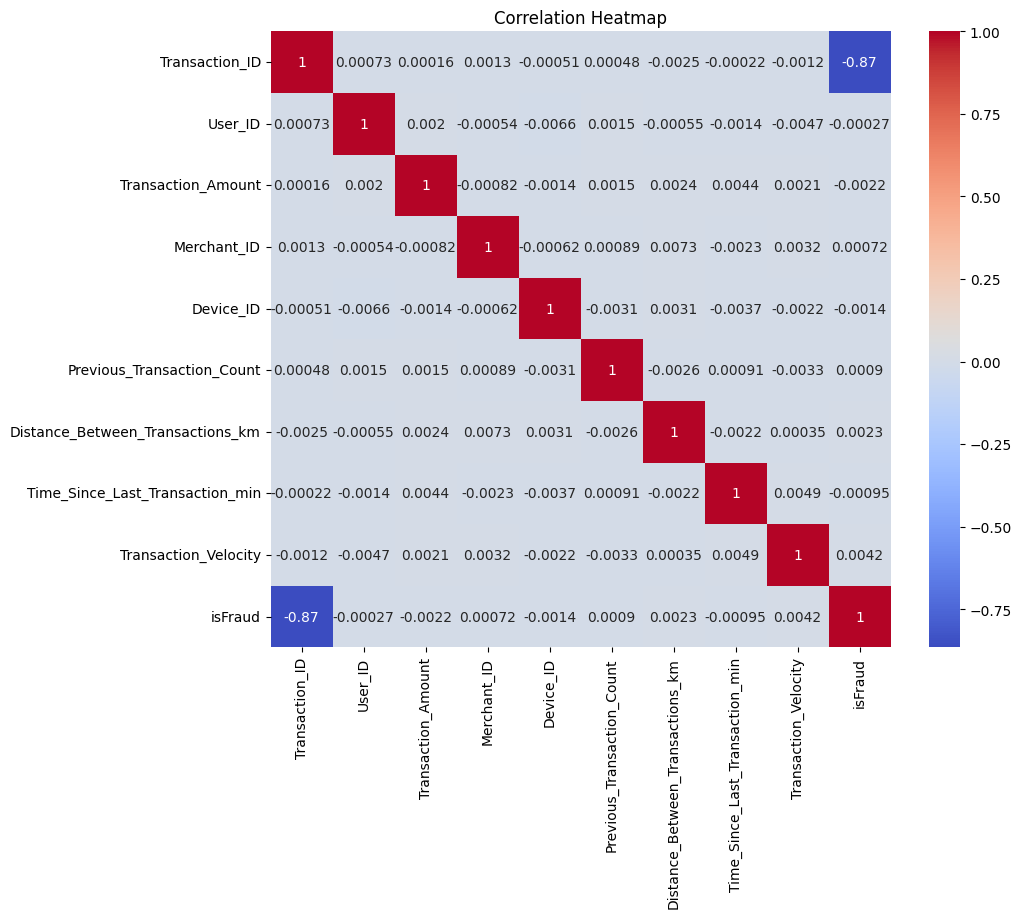

isFraud                             1.000000
Transaction_Velocity                0.004160
Distance_Between_Transactions_km    0.002299
Previous_Transaction_Count          0.000904
Merchant_ID                         0.000720
User_ID                            -0.000266
Time_Since_Last_Transaction_min    -0.000951
Device_ID                          -0.001405
Transaction_Amount                 -0.002166
Transaction_ID                     -0.866025
Name: isFraud, dtype: float64


In [3]:
# Print dataset info
print(df.info())

# Summary statistics
print(df.describe())

# Class distribution plot
sns.countplot(x='isFraud', data=df)
plt.title('Class Distribution')
plt.show()

# Correlation heatmap for numerical features
numerical_df = df.select_dtypes(include=['int64', 'float64'])
corr = numerical_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

# Print correlations with target
print(corr['isFraud'].sort_values(ascending=False))

## Feature Engineering

In [4]:
# Combine Transaction_Date and Transaction_Time into a single datetime column
df['Transaction_DateTime'] = pd.to_datetime(df['Transaction_Date'] + ' ' + df['Transaction_Time'])

# Extract temporal features
df['Transaction_Hour'] = df['Transaction_DateTime'].dt.hour
df['Transaction_Day'] = df['Transaction_DateTime'].dt.day
df['Transaction_Month'] = df['Transaction_DateTime'].dt.month
df['Transaction_Weekday'] = df['Transaction_DateTime'].dt.weekday

# Drop original date/time columns
df.drop(['Transaction_Date', 'Transaction_Time', 'Transaction_DateTime'], axis=1, inplace=True)

# Log transform skewed numerical features
df['Log_Transaction_Amount'] = np.log1p(df['Transaction_Amount'])

# Additional interaction features for better signal
df['Velocity_Distance_Interact'] = df['Transaction_Velocity'] * df['Distance_Between_Transactions_km']
df['Amount_Velocity_Interact'] = df['Transaction_Amount'] * df['Transaction_Velocity']
df['Time_Distance_Interact'] = df['Time_Since_Last_Transaction_min'] * df['Distance_Between_Transactions_km']

# Cyclical encoding for hour and weekday
df['Hour_sin'] = np.sin(2 * np.pi * df['Transaction_Hour'] / 24)
df['Hour_cos'] = np.cos(2 * np.pi * df['Transaction_Hour'] / 24)
df['Weekday_sin'] = np.sin(2 * np.pi * df['Transaction_Weekday'] / 7)
df['Weekday_cos'] = np.cos(2 * np.pi * df['Transaction_Weekday'] / 7)

# Display updated dataframe head
df.head()

C:\Users\ghosh\AppData\Local\Temp\ipykernel_24252\2857254214.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Transaction_DateTime'] = pd.to_datetime(df['Transaction_Date'] + ' ' + df['Transaction_Time'])


,Transaction_ID,User_ID,Transaction_Amount,Transaction_Location,Merchant_ID,Device_ID,Card_Type,Transaction_Currency,Transaction_Status,Previous_Transaction_Count,...,Transaction_Month,Transaction_Weekday,Log_Transaction_Amount,Velocity_Distance_Interact,Amount_Velocity_Interact,Time_Distance_Interact,Hour_sin,Hour_cos,Weekday_sin,Weekday_cos
0,1001,68389745,69635000,Surkhandarya,6710,2060,UzCard,UZS,Successful,35,...,1,0,18.058778,17405.95,348175000,104435.70,0.0,1.0,0.0,1.0
1,1002,42122340,53486000,Namangan,6498,2797,UzCard,USD,Successful,35,...,1,0,17.794931,39069.36,481374000,4657935.92,0.0,1.0,0.0,1.0
2,1003,87539955,24262000,Navoiy,5039,2519,Humo,UZS,Reversed,25,...,1,0,17.004422,33462.45,169834000,631006.20,0.0,1.0,0.0,1.0
3,1004,98657863,56019000,Bukhara,6115,2641,Humo,UZS,Failed,44,...,1,0,17.841201,719.43,56019000,29496.63,0.0,1.0,0.0,1.0
4,1005,88084360,87823000,Andijan,5072,2923,Humo,UZS,Failed,21,...,1,0,18.290834,37528.48,702584000,2148505.48,0.0,1.0,0.0,1.0


## Save Processed Dataset

In [5]:
# Define path to save processed data
processed_path = Path('c:/Users/ghosh/Desktop/Predictive Transaction Intelligence using for BFSI/Dataset/card_fraud_processed.csv')

# Create directory if not exists
processed_path.parent.mkdir(parents=True, exist_ok=True)

# Save the processed dataset
df.to_csv(processed_path, index=False)
print(f'Processed dataset saved to {processed_path}')

Processed dataset saved to c:\Users\ghosh\Desktop\Predictive Transaction Intelligence using for BFSI\Dataset\card_fraud_processed.csv


## Prepare Data for Modeling

In [11]:
# Separate features and target
X = df.drop('isFraud', axis=1)
y = df['isFraud']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define categorical and numerical columns
categorical_cols = [
    'Transaction_Location', 'Card_Type', 'Transaction_Currency',
    'Transaction_Status', 'Authentication_Method', 'Transaction_Category'
]  # Transaction_Weekday removed since cyclically encoded
numerical_cols = [
    'Transaction_Amount', 'Previous_Transaction_Count', 'Distance_Between_Transactions_km',
    'Time_Since_Last_Transaction_min', 'Transaction_Velocity', 'Transaction_Hour',
    'Transaction_Day', 'Transaction_Month', 'Log_Transaction_Amount',
    'Velocity_Distance_Interact', 'Amount_Velocity_Interact', 'Time_Distance_Interact',
    'Hour_sin', 'Hour_cos', 'Weekday_sin', 'Weekday_cos'
]

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=True), categorical_cols)
    ])

In [12]:
print("Available columns in X_train:", X_train.columns.tolist())

Available columns in X_train: ['Transaction_ID', 'User_ID', 'Transaction_Amount', 'Transaction_Location', 'Merchant_ID', 'Device_ID', 'Card_Type', 'Transaction_Currency', 'Transaction_Status', 'Previous_Transaction_Count', 'Distance_Between_Transactions_km', 'Time_Since_Last_Transaction_min', 'Authentication_Method', 'Transaction_Velocity', 'Transaction_Category', 'Transaction_Hour', 'Transaction_Day', 'Transaction_Month', 'Transaction_Weekday', 'Log_Transaction_Amount', 'Velocity_Distance_Interact', 'Amount_Velocity_Interact', 'Time_Distance_Interact', 'Hour_sin', 'Hour_cos', 'Weekday_sin', 'Weekday_cos']


## Train and Tune Multiple Models

In [ ]:
import pandas as pd
from pathlib import Path  
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from scipy.stats import uniform, randint, loguniform
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import time
from tqdm import tqdm
import logging

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

logger.info("Starting model training script")

DATA_PATH = Path("c:/Users/ghosh/Desktop/Predictive Transaction Intelligence using for BFSI/Dataset/card_fraud_processed.csv")

df = pd.read_csv(DATA_PATH)
data = df.copy()

logger.info(f"Dataset loaded: {df.shape[0]} rows, {df.shape[1]} columns")

# Define models with tuned params (reduced ranges for speed)
models = {
    'Logistic Regression': {
        'model': LogisticRegression(random_state=42),
        'params': {
            'classifier__C': loguniform(1e-2, 10),
            'classifier__max_iter': randint(500, 2000),
            'classifier__solver': ['lbfgs', 'liblinear']
        }
    },
    'Random Forest': {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'classifier__n_estimators': randint(50, 150),
            'classifier__max_depth': [None] + list(randint(5, 30).rvs(5)),
            'classifier__min_samples_split': randint(2, 10),
            'classifier__min_samples_leaf': randint(1, 5),
            'classifier__max_features': uniform(0.3, 0.6),
            'classifier__bootstrap': [True]
        }
    },
    'XGBoost': {
        'model': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
        'params': {
            'classifier__n_estimators': randint(50, 150),
            'classifier__max_depth': randint(3, 10),
            'classifier__learning_rate': loguniform(1e-2, 0.3),
            'classifier__subsample': uniform(0.6, 0.3),
            'classifier__colsample_bytree': uniform(0.6, 0.3),
            'classifier__gamma': uniform(0, 2),
            'classifier__min_child_weight': randint(1, 5),
            'classifier__reg_alpha': loguniform(1e-3, 1),
            'classifier__reg_lambda': loguniform(1e-3, 1)
        }
    },
    'LightGBM': {
        'model': LGBMClassifier(random_state=42, verbose=-1),  # Added verbose=-1 for less output
        'params': {
            'classifier__n_estimators': randint(50, 150),
            'classifier__max_depth': [-1] + list(randint(5, 30).rvs(5)),
            'classifier__learning_rate': loguniform(1e-2, 0.3),
            'classifier__num_leaves': randint(20, 80),
            'classifier__min_child_samples': randint(10, 100),
            'classifier__subsample': uniform(0.6, 0.3),
            'classifier__colsample_bytree': uniform(0.6, 0.3),
            'classifier__reg_alpha': loguniform(1e-3, 1),
            'classifier__reg_lambda': loguniform(1e-3, 1)
        }
    }
}

# Results storage
results = {}
best_pipelines = {}

# Progress tracking
model_times = []
pbar = tqdm(models.items(), total=len(models), desc="Training Models", unit="model")
logger.info("Beginning hyperparameter tuning and evaluation for all models")

for idx, (name, info) in enumerate(pbar):
    logger.info(f"Starting tuning for {name} ({idx+1}/{len(models)})")
    
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', info['model'])])
    
    search = RandomizedSearchCV(pipeline, info['params'], n_iter=20, cv=3, scoring='f1', 
                                random_state=42, n_jobs=-1, verbose=1)  # Set verbose=1 for iteration logs
    
    # Time the fitting
    fit_start_time = time.time()
    logger.info(f"Hyperparameter search started for {name}...")
    search.fit(X_train, y_train)
    fit_end_time = time.time()
    fit_duration = fit_end_time - fit_start_time
    
    model_times.append(fit_duration)
    logger.info(f"Hyperparameter search completed for {name} in {fit_duration:.2f} seconds")
    
    # Update progress bar with details
    if model_times:
        avg_time = sum(model_times) / len(model_times)
        remaining_models = len(models) - (idx + 1)
        eta_seconds = avg_time * remaining_models
        eta_min = eta_seconds / 60
        pbar.set_postfix({
            'Time per model': f'{avg_time:.1f}s',
            'ETA remaining': f'{eta_min:.1f} min',
            'Progress': f'{((idx + 1) / len(models)) * 100:.1f}%'
        })
    
    best_pipeline = search.best_estimator_
    best_pipelines[name] = best_pipeline
    logger.info(f'{name} Best Params: {search.best_params_}')
    
    y_pred = best_pipeline.predict(X_test)
    y_prob = best_pipeline.predict_proba(X_test)[:, 1] if hasattr(best_pipeline.named_steps['classifier'], 'predict_proba') else None
    
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    roc_auc = roc_auc_score(y_test, y_prob) if y_prob is not None else 'N/A'
    
    results[name] = {
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'ROC AUC': roc_auc
    }
    
    logger.info(f'{name} Classification Report:\n{classification_report(y_test, y_pred, zero_division=0)}')

# Close progress bar
pbar.close()

# Display results
results_df = pd.DataFrame(results).T
logger.info("All models trained. Final results:")
print(results_df)

total_time = sum(model_times)
logger.info(f"Total training time: {total_time:.2f} seconds ({total_time/60:.2f} minutes)")
logger.info("Model training script completed successfully")

2025-10-27 18:59:18,181 - INFO - Starting model training script
2025-10-27 18:59:18,755 - INFO - Dataset loaded: 100000 rows, 28 columns
c:\Users\ghosh\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
Training Models:   0%|          | 0/4 [00:00<?, ?model/s]2025-10-27 18:59:18,784 - INFO - Beginning hyperparameter tuning and evaluation for all models
2025-10-27 18:59:18,784 - INFO - Starting tuning for Logistic Regression (1/4)
2025-10-27 18:59:18,784 - INFO - Hyperparameter search started for Logistic Regression...


Fitting 3 folds for each of 20 candidates, totalling 60 fits


2025-10-27 18:59:34,213 - INFO - Hyperparameter search completed for Logistic Regression in 15.43 seconds
Training Models:   0%|          | 0/4 [00:15<?, ?model/s, Time per model=15.4s, ETA remaining=0.8 min, Progress=25.0%]2025-10-27 18:59:34,213 - INFO - Logistic Regression Best Params: {'classifier__C': 9.476210031010519, 'classifier__max_iter': 1684, 'classifier__solver': 'liblinear'}
2025-10-27 18:59:34,346 - INFO - Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10000
           1       1.00      1.00      1.00     10000

    accuracy                           1.00     20000
   macro avg       1.00      1.00      1.00     20000
weighted avg       1.00      1.00      1.00     20000

Training Models:  25%|██▌       | 1/4 [00:15<00:46, 15.56s/model, Time per model=15.4s, ETA remaining=0.8 min, Progress=25.0%]2025-10-27 18:59:34,364 - INFO - Starting tuning for Random Forest (2/4)
2025-1

Fitting 3 folds for each of 20 candidates, totalling 60 fits


2025-10-27 19:03:19,301 - INFO - Hyperparameter search completed for Random Forest in 224.94 seconds
Training Models:  25%|██▌       | 1/4 [04:00<00:46, 15.56s/model, Time per model=120.2s, ETA remaining=4.0 min, Progress=50.0%]2025-10-27 19:03:19,303 - INFO - Random Forest Best Params: {'classifier__bootstrap': True, 'classifier__max_depth': 8, 'classifier__max_features': 0.30046725950460856, 'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 6, 'classifier__n_estimators': 82}
2025-10-27 19:03:19,702 - INFO - Random Forest Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10000
           1       1.00      1.00      1.00     10000

    accuracy                           1.00     20000
   macro avg       1.00      1.00      1.00     20000
weighted avg       1.00      1.00      1.00     20000

Training Models:  50%|█████     | 2/4 [04:00<04:37, 138.97s/model, Time per model=120.2s, ETA remaining

Fitting 3 folds for each of 20 candidates, totalling 60 fits


2025-10-27 19:05:42,806 - INFO - Hyperparameter search completed for XGBoost in 143.10 seconds
Training Models:  50%|█████     | 2/4 [06:24<04:37, 138.97s/model, Time per model=127.8s, ETA remaining=2.1 min, Progress=75.0%]2025-10-27 19:05:42,810 - INFO - XGBoost Best Params: {'classifier__colsample_bytree': 0.7760253496991545, 'classifier__gamma': 1.930510614528276, 'classifier__learning_rate': 0.07882485664694612, 'classifier__max_depth': 7, 'classifier__min_child_weight': 1, 'classifier__n_estimators': 78, 'classifier__reg_alpha': 0.2550298070162892, 'classifier__reg_lambda': 0.0016736010167825778, 'classifier__subsample': 0.8960660809801552}
2025-10-27 19:05:43,071 - INFO - XGBoost Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10000
           1       1.00      1.00      1.00     10000

    accuracy                           1.00     20000
   macro avg       1.00      1.00      1.00     20000
weighted a

Fitting 3 folds for each of 20 candidates, totalling 60 fits


2025-10-27 19:06:08,382 - INFO - Hyperparameter search completed for LightGBM in 25.31 seconds
Training Models:  75%|███████▌  | 3/4 [06:49<02:20, 140.98s/model, Time per model=102.2s, ETA remaining=0.0 min, Progress=100.0%]2025-10-27 19:06:08,382 - INFO - LightGBM Best Params: {'classifier__colsample_bytree': 0.8677676995469933, 'classifier__learning_rate': 0.06261435181296006, 'classifier__max_depth': 6, 'classifier__min_child_samples': 98, 'classifier__n_estimators': 111, 'classifier__num_leaves': 52, 'classifier__reg_alpha': 0.006552344878295666, 'classifier__reg_lambda': 0.08771429187378862, 'classifier__subsample': 0.6001561130985947}
2025-10-27 19:06:08,627 - INFO - LightGBM Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10000
           1       1.00      1.00      1.00     10000

    accuracy                           1.00     20000
   macro avg       1.00      1.00      1.00     20000
weighted avg  

                     Precision  Recall  F1 Score  ROC AUC
Logistic Regression     0.9995  0.9998   0.99965      1.0
Random Forest           1.0000  0.9996   0.99980      1.0
XGBoost                 1.0000  0.9996   0.99980      1.0
LightGBM                1.0000  0.9996   0.99980      1.0


## Generate Plots for Model Results

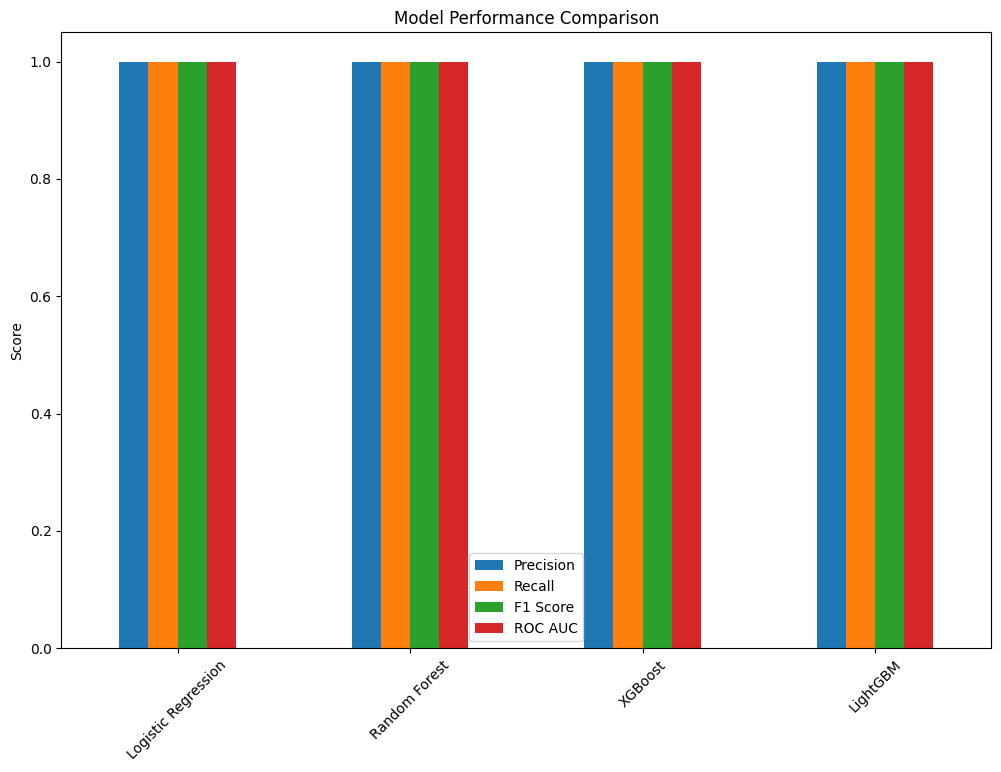

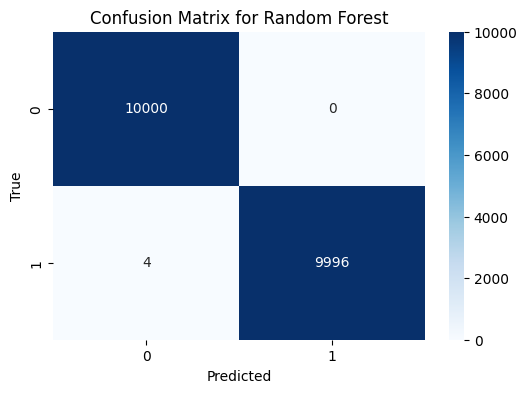

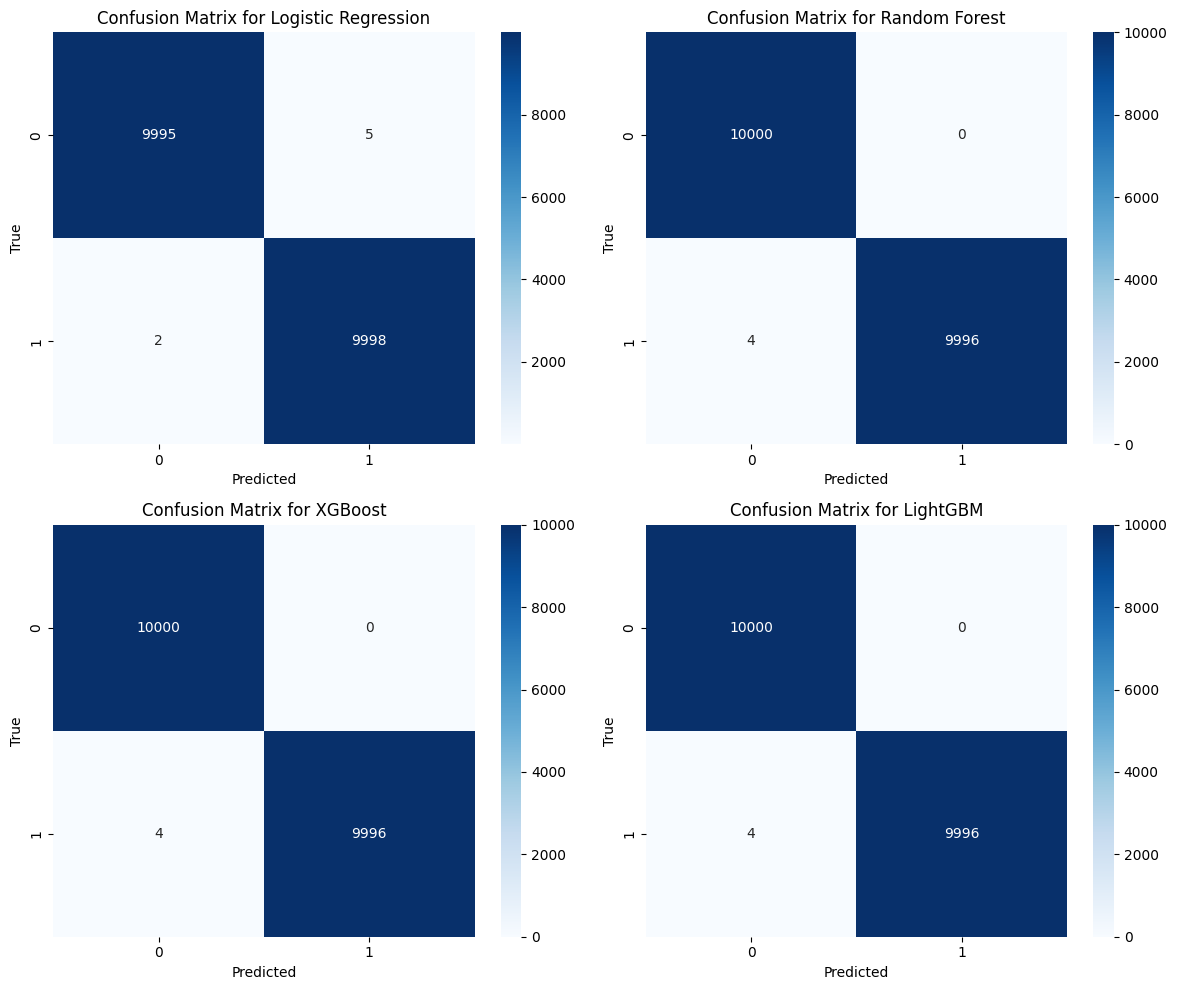

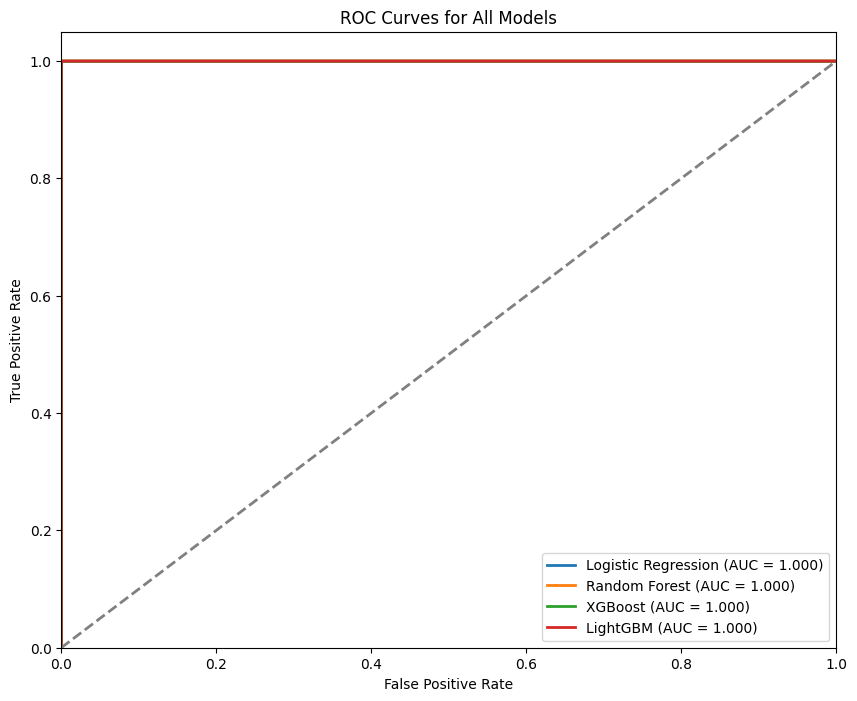

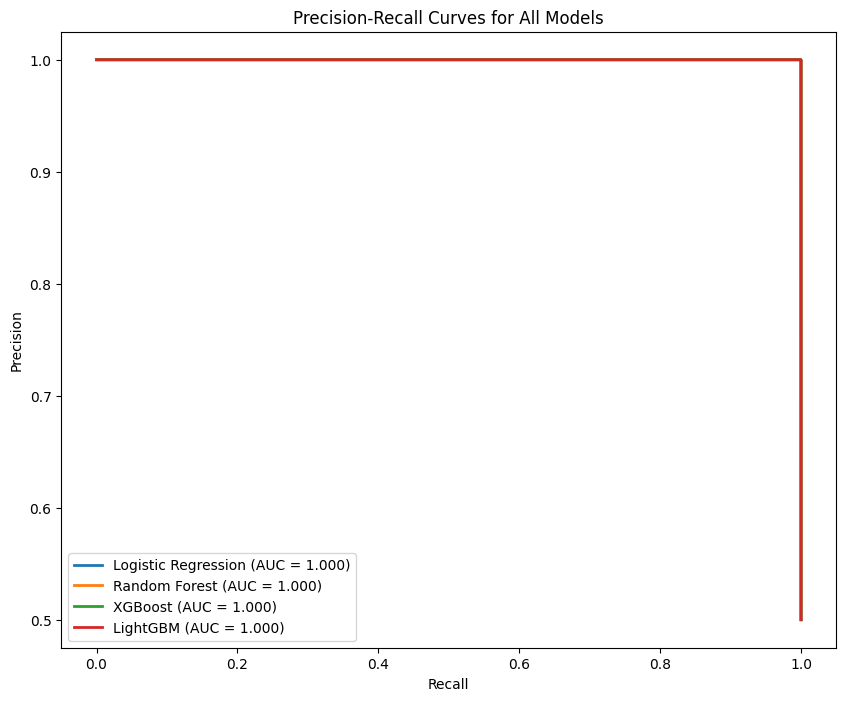

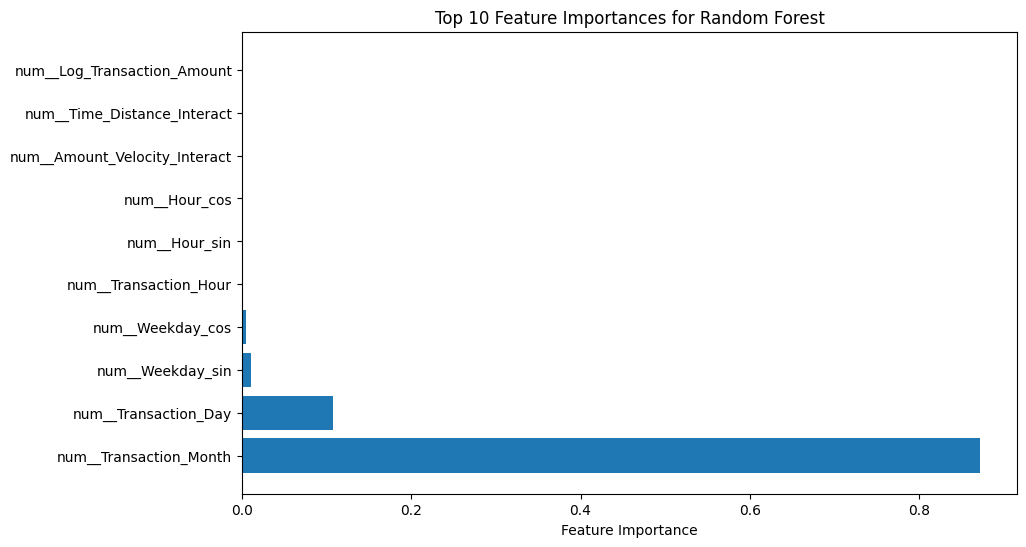

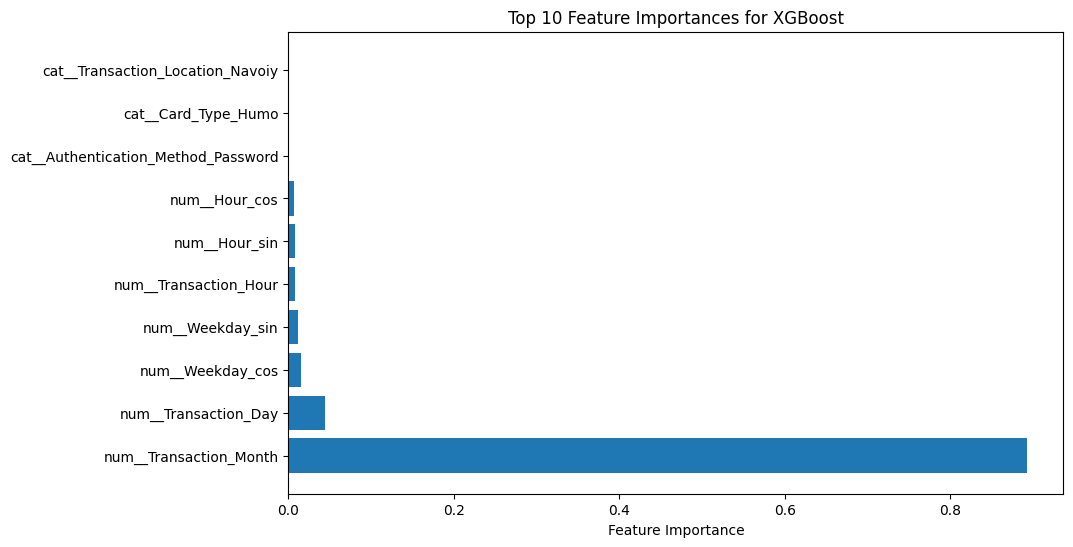

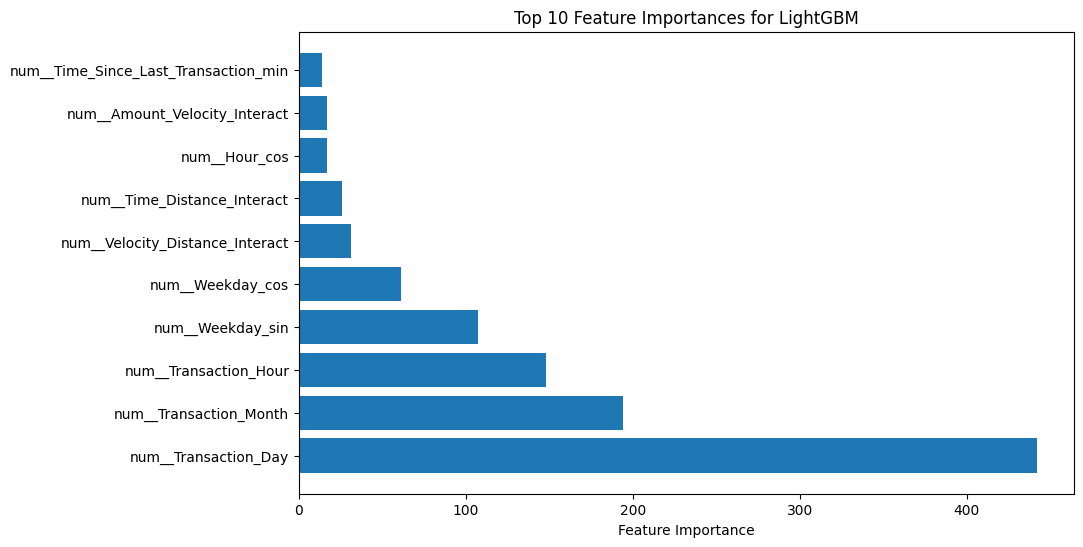

All plots generated and saved as PNG files.


In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve

# Bar plot for model comparison (existing)
results_df.plot(kind='bar', figsize=(12, 8))
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.savefig('model_comparison.png')
plt.show()

# Select best model based on F1 Score (existing)
best_model_name = results_df['F1 Score'].idxmax()
best_pipeline = best_pipelines[best_model_name]

# Confusion matrix for the best model (existing)
y_pred = best_pipeline.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix for {best_model_name}')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig(f'confusion_matrix_{best_model_name}.png')
plt.show()

# Extended: Confusion matrices for ALL models
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()
for idx, (name, pipeline) in enumerate(best_pipelines.items()):
    y_pred = pipeline.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx])
    axes[idx].set_title(f'Confusion Matrix for {name}')
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('True')
plt.tight_layout()
plt.savefig('confusion_matrices_all_models.png')
plt.show()

# Extended: ROC Curves for ALL models (on a single plot for comparison)
plt.figure(figsize=(10, 8))
for name, pipeline in best_pipelines.items():
    if hasattr(pipeline.named_steps['classifier'], 'predict_proba'):
        y_prob = pipeline.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for All Models')
plt.legend(loc="lower right")
plt.savefig('roc_curves_all_models.png')
plt.show()

# Extended: Precision-Recall Curves for ALL models (useful for imbalanced data like fraud)
plt.figure(figsize=(10, 8))
for name, pipeline in best_pipelines.items():
    if hasattr(pipeline.named_steps['classifier'], 'predict_proba'):
        y_prob = pipeline.predict_proba(X_test)[:, 1]
        precision, recall, _ = precision_recall_curve(y_test, y_prob)
        pr_auc = auc(recall, precision)
        plt.plot(recall, precision, lw=2, label=f'{name} (AUC = {pr_auc:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves for All Models')
plt.legend(loc="lower left")
plt.savefig('pr_curves_all_models.png')
plt.show()

# Extended: Feature Importance for Tree-Based Models (RF, XGBoost, LightGBM)
tree_models = ['Random Forest', 'XGBoost', 'LightGBM']
for name in tree_models:
    if name in best_pipelines:
        pipeline = best_pipelines[name]
        classifier = pipeline.named_steps['classifier']
        
        # Get feature names after preprocessing
        feature_names = (pipeline.named_steps['preprocessor']
                         .get_feature_names_out()
                         .tolist())
        
        if hasattr(classifier, 'feature_importances_'):
            importances = classifier.feature_importances_
            indices = importances.argsort()[-10:]  # Top 10 features
            plt.figure(figsize=(10, 6))
            plt.barh(range(len(indices)), importances[indices])
            plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
            plt.xlabel('Feature Importance')
            plt.title(f'Top 10 Feature Importances for {name}')
            plt.gca().invert_yaxis()
            plt.savefig(f'feature_importance_{name}.png')
            plt.show()

print("All plots generated and saved as PNG files.")

## Save the Trained Models

In [16]:
# Define artifacts path
artifacts_path = Path('c:/Users/ghosh/Desktop/Predictive Transaction Intelligence using for BFSI/models/module_2/artifacts')

# Create directory if not exists
artifacts_path.mkdir(parents=True, exist_ok=True)

# Save each tuned model (already trained)
for name, pipeline in best_pipelines.items():
    save_path = artifacts_path / f'{name.replace(" ", "_")}_tuned_model.pkl'
    joblib.dump(pipeline, save_path)
    print(f'{name} tuned model saved to {save_path}')

Logistic Regression tuned model saved to c:\Users\ghosh\Desktop\Predictive Transaction Intelligence using for BFSI\models\module_2\artifacts\Logistic_Regression_tuned_model.pkl
Random Forest tuned model saved to c:\Users\ghosh\Desktop\Predictive Transaction Intelligence using for BFSI\models\module_2\artifacts\Random_Forest_tuned_model.pkl
XGBoost tuned model saved to c:\Users\ghosh\Desktop\Predictive Transaction Intelligence using for BFSI\models\module_2\artifacts\XGBoost_tuned_model.pkl
LightGBM tuned model saved to c:\Users\ghosh\Desktop\Predictive Transaction Intelligence using for BFSI\models\module_2\artifacts\LightGBM_tuned_model.pkl


Training Models:   0%|          | 0/4 [00:00<?, ?model/s]2025-10-27 22:30:13,403 - INFO - Starting tuning for Logistic Regression (1/4)


Fitting 3 folds for each of 20 candidates, totalling 60 fits


Training Models:   0%|          | 0/4 [00:38<?, ?model/s, Time per model=38.9s, ETA remaining=1.9 min, Progress=25.0%]

Logistic Regression Best Params: {'classifier__C': 9.476210031010519, 'classifier__max_iter': 1684, 'classifier__solver': 'liblinear'}


Training Models:  25%|██▌       | 1/4 [00:39<01:57, 39.21s/model, Time per model=38.9s, ETA remaining=1.9 min, Progress=25.0%]2025-10-27 22:30:52,612 - INFO - Starting tuning for Random Forest (2/4)


Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10000
           1       1.00      1.00      1.00     10000

    accuracy                           1.00     20000
   macro avg       1.00      1.00      1.00     20000
weighted avg       1.00      1.00      1.00     20000

Fitting 3 folds for each of 20 candidates, totalling 60 fits


Training Models:  25%|██▌       | 1/4 [07:54<01:57, 39.21s/model, Time per model=237.2s, ETA remaining=7.9 min, Progress=50.0%]

Random Forest Best Params: {'classifier__bootstrap': True, 'classifier__max_depth': 8, 'classifier__max_features': 0.30046725950460856, 'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 6, 'classifier__n_estimators': 82}


Training Models:  50%|█████     | 2/4 [07:55<09:05, 272.78s/model, Time per model=237.2s, ETA remaining=7.9 min, Progress=50.0%]2025-10-27 22:38:08,898 - INFO - Starting tuning for XGBoost (3/4)


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10000
           1       1.00      1.00      1.00     10000

    accuracy                           1.00     20000
   macro avg       1.00      1.00      1.00     20000
weighted avg       1.00      1.00      1.00     20000

Fitting 3 folds for each of 20 candidates, totalling 60 fits


c:\Users\ghosh\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
c:\Users\ghosh\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
Training Models:  50%|█████     | 2/4 [11:53<09:05, 272.78s/model, Time per model=237.6s, ETA remaining=4.0 min, Progress=75.0%]

XGBoost Best Params: {'classifier__colsample_bytree': 0.7760253496991545, 'classifier__gamma': 1.930510614528276, 'classifier__learning_rate': 0.07882485664694612, 'classifier__max_depth': 7, 'classifier__min_child_weight': 1, 'classifier__n_estimators': 78, 'classifier__reg_alpha': 0.2550298070162892, 'classifier__reg_lambda': 0.0016736010167825778, 'classifier__subsample': 0.8960660809801552}


Training Models:  75%|███████▌  | 3/4 [11:54<04:17, 257.29s/model, Time per model=237.6s, ETA remaining=4.0 min, Progress=75.0%]2025-10-27 22:42:07,743 - INFO - Starting tuning for LightGBM (4/4)


XGBoost Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10000
           1       1.00      1.00      1.00     10000

    accuracy                           1.00     20000
   macro avg       1.00      1.00      1.00     20000
weighted avg       1.00      1.00      1.00     20000

Fitting 3 folds for each of 20 candidates, totalling 60 fits


Training Models:  75%|███████▌  | 3/4 [12:34<04:17, 257.29s/model, Time per model=188.1s, ETA remaining=0.0 min, Progress=100.0%]

LightGBM Best Params: {'classifier__colsample_bytree': 0.8677676995469933, 'classifier__learning_rate': 0.06261435181296006, 'classifier__max_depth': 6, 'classifier__min_child_samples': 98, 'classifier__n_estimators': 111, 'classifier__num_leaves': 52, 'classifier__reg_alpha': 0.006552344878295666, 'classifier__reg_lambda': 0.08771429187378862, 'classifier__subsample': 0.6001561130985947}


Training Models: 100%|██████████| 4/4 [12:34<00:00, 188.66s/model, Time per model=188.1s, ETA remaining=0.0 min, Progress=100.0%]

LightGBM Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10000
           1       1.00      1.00      1.00     10000

    accuracy                           1.00     20000
   macro avg       1.00      1.00      1.00     20000
weighted avg       1.00      1.00      1.00     20000

                     Precision  Recall  F1 Score  ROC AUC
Logistic Regression     0.9995  0.9998   0.99965      1.0
Random Forest           1.0000  0.9996   0.99980      1.0
XGBoost                 1.0000  0.9996   0.99980      1.0
LightGBM                1.0000  0.9996   0.99980      1.0


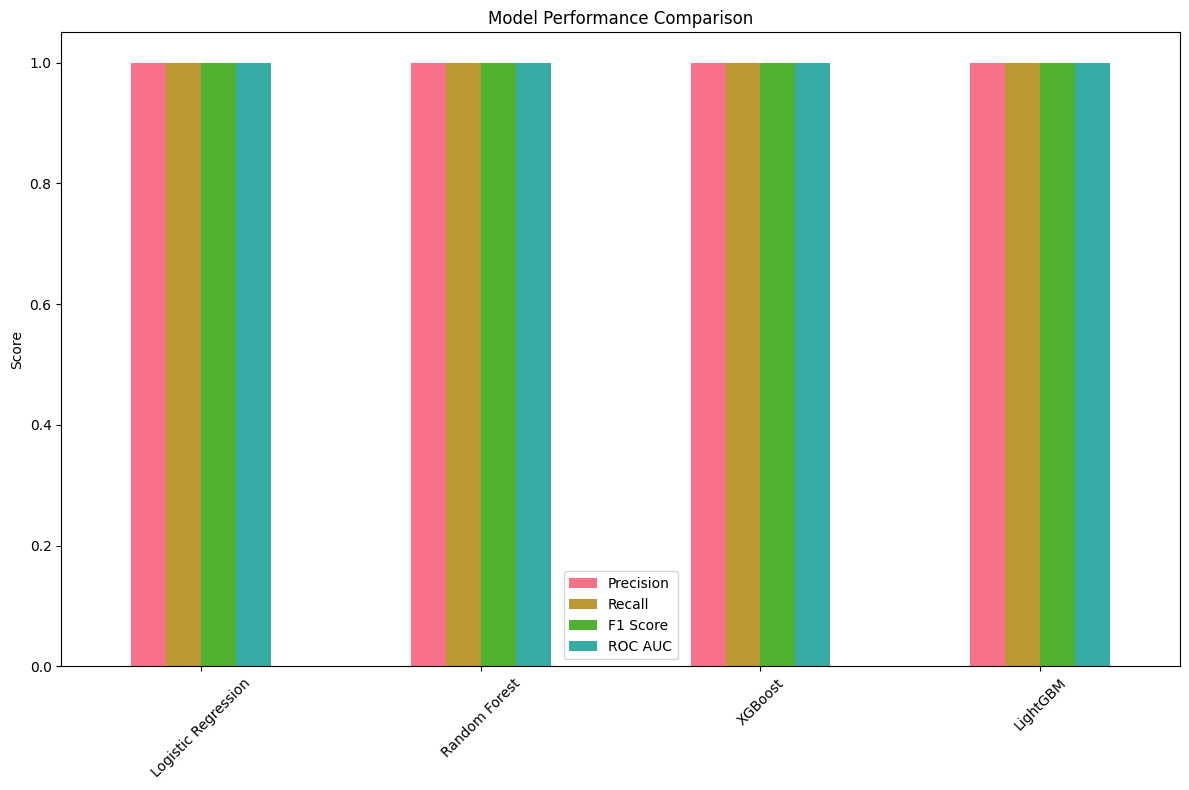

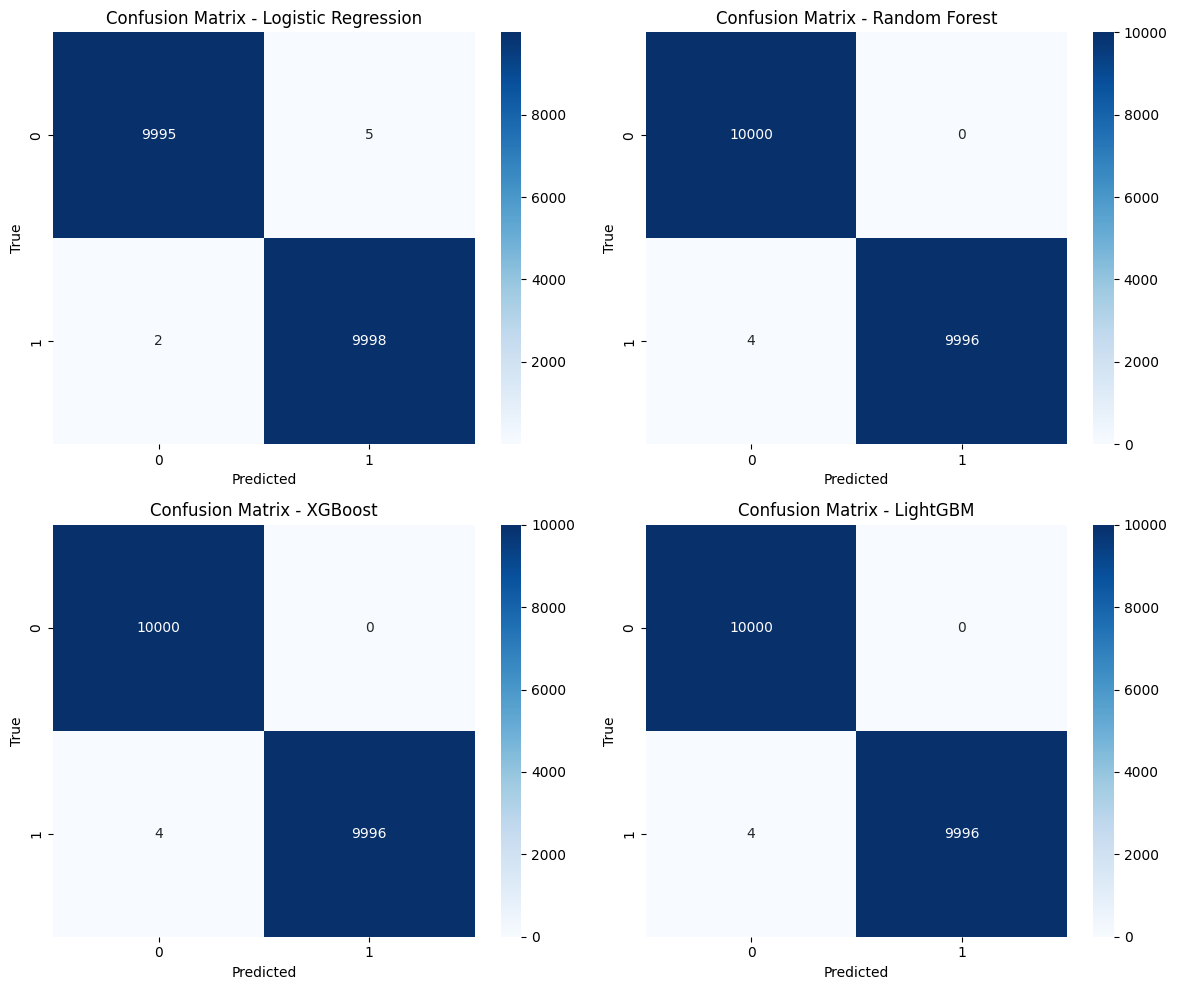

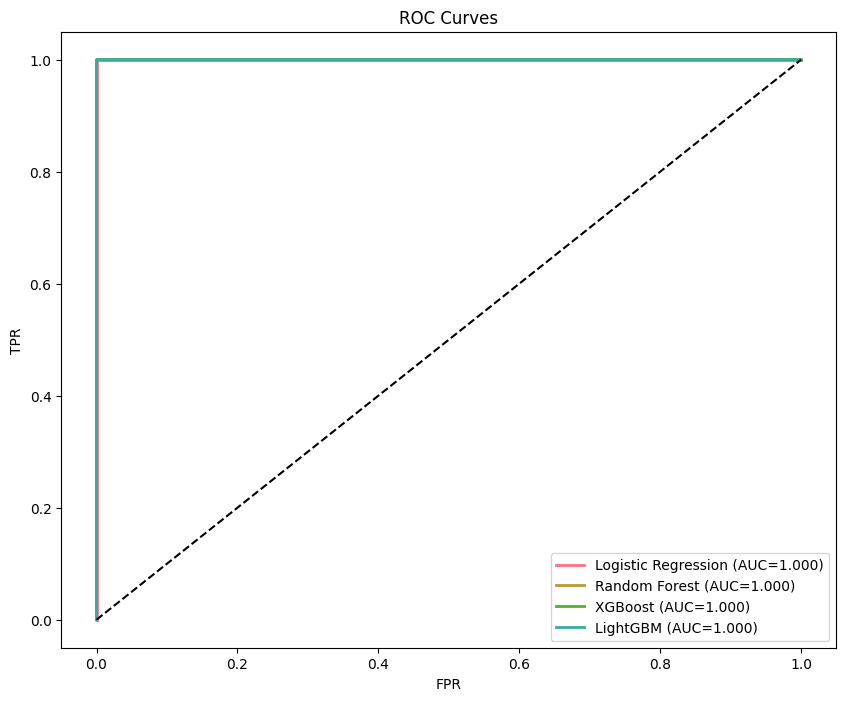

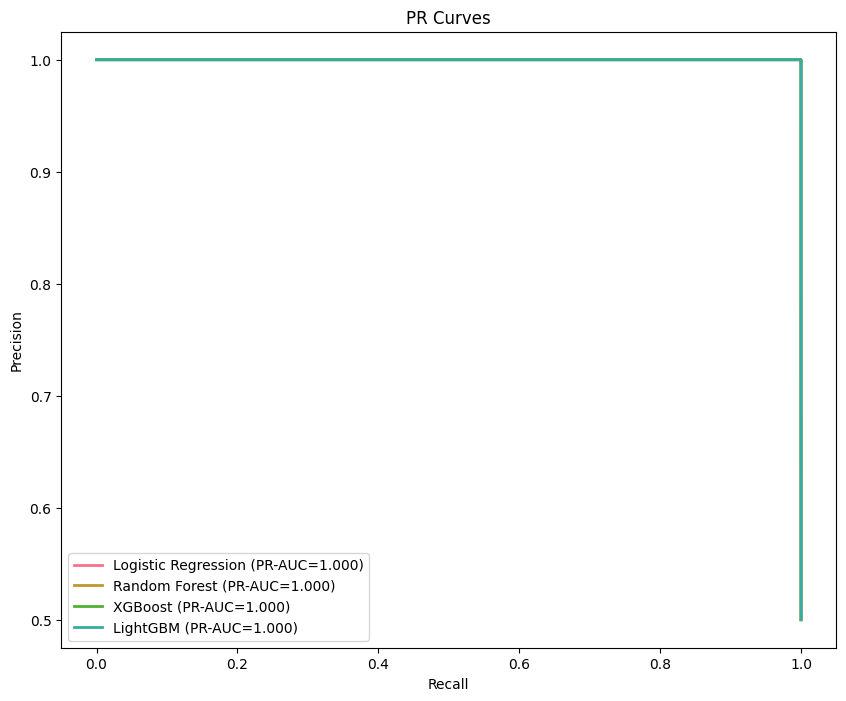

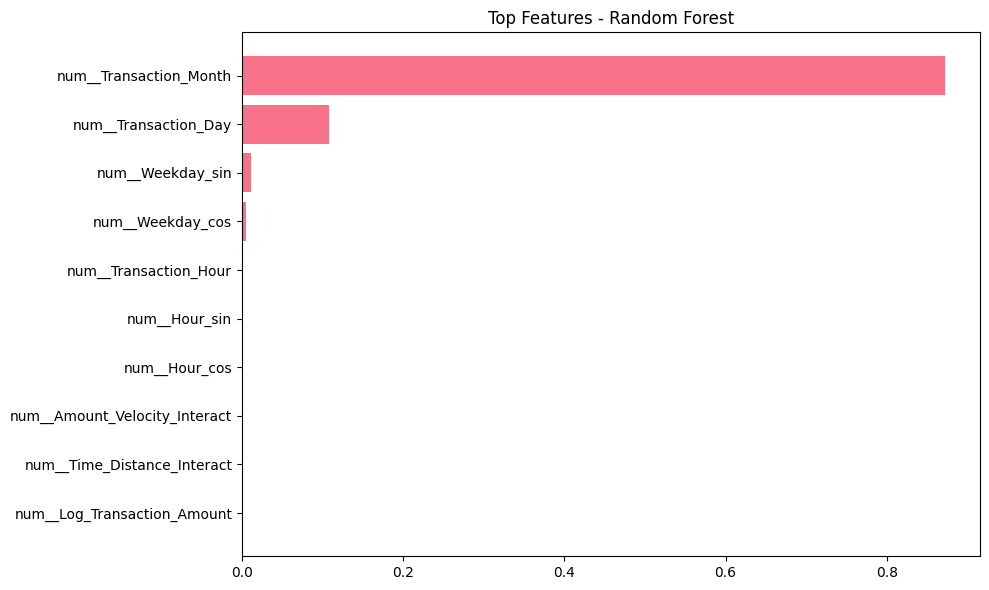

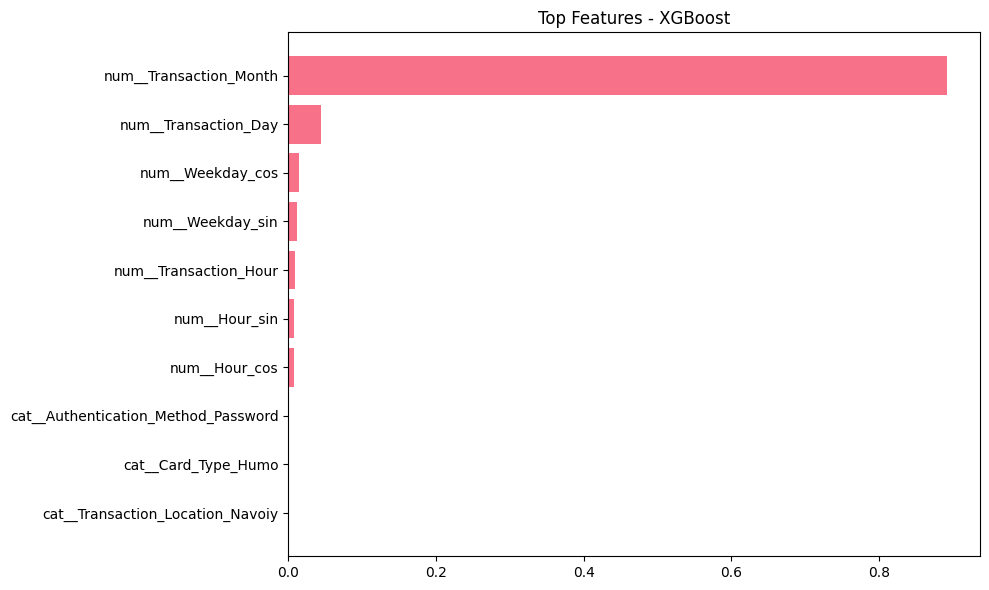

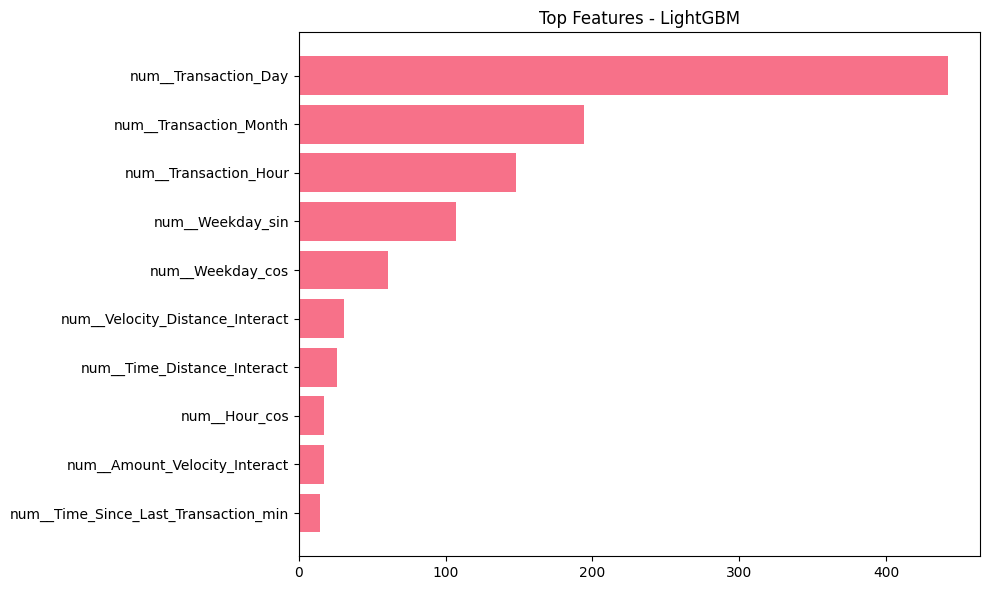

c:\Users\ghosh\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


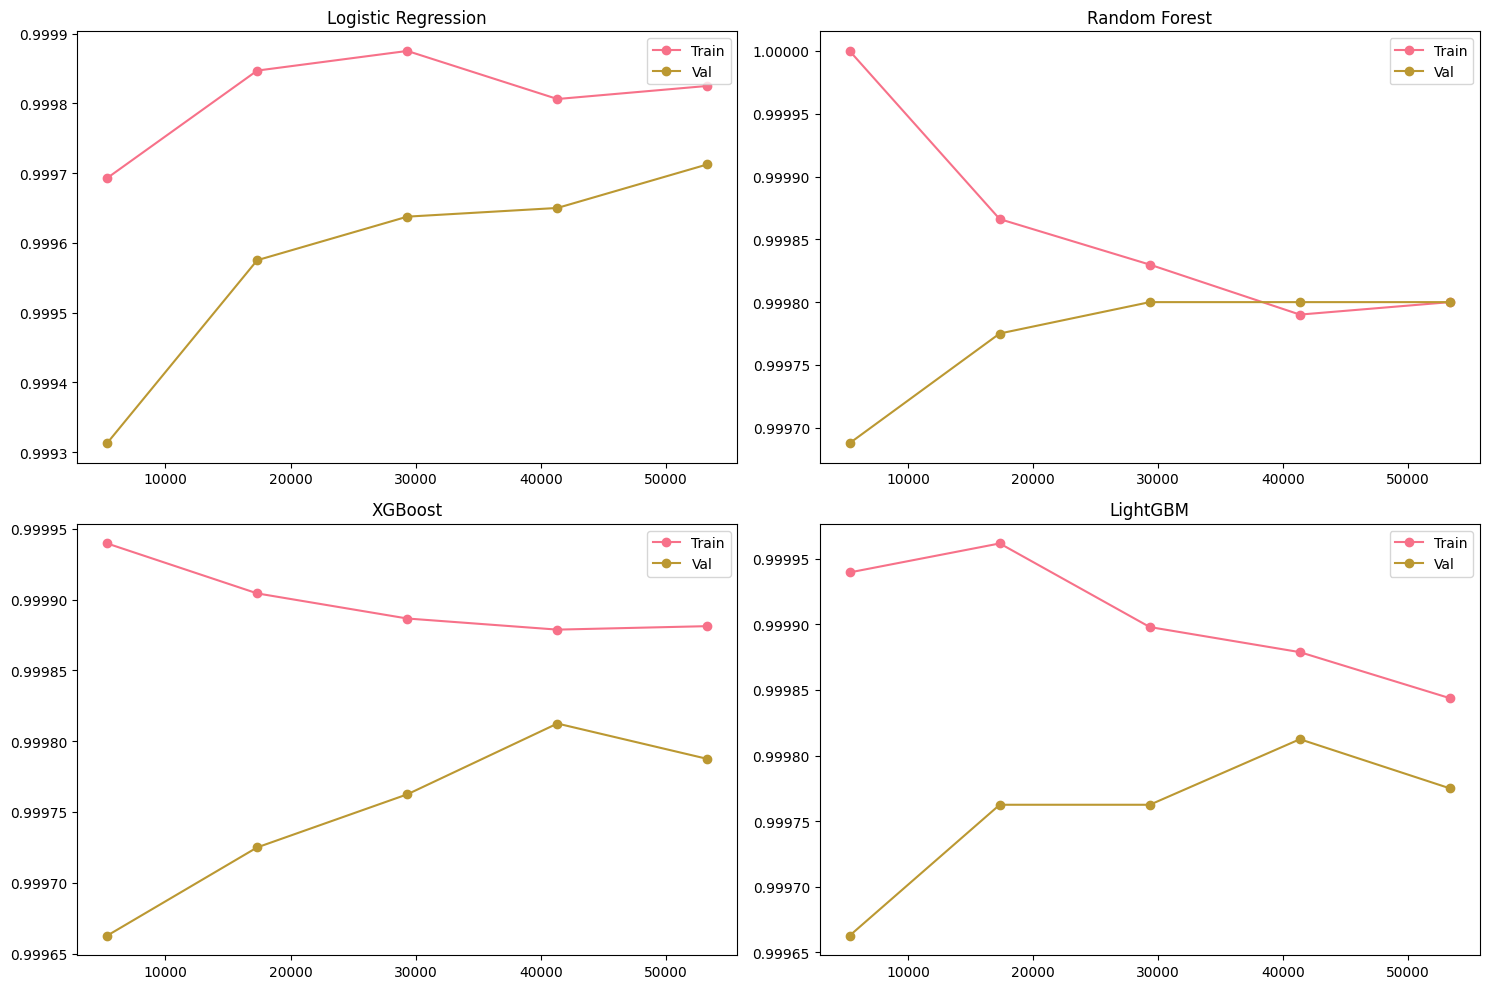

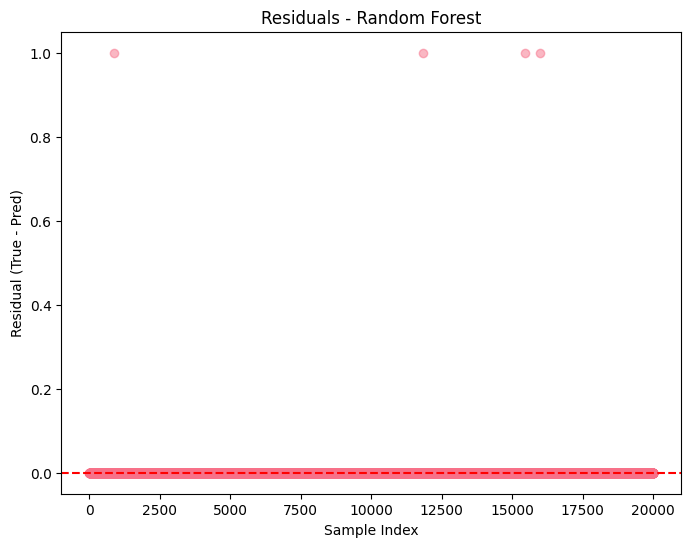

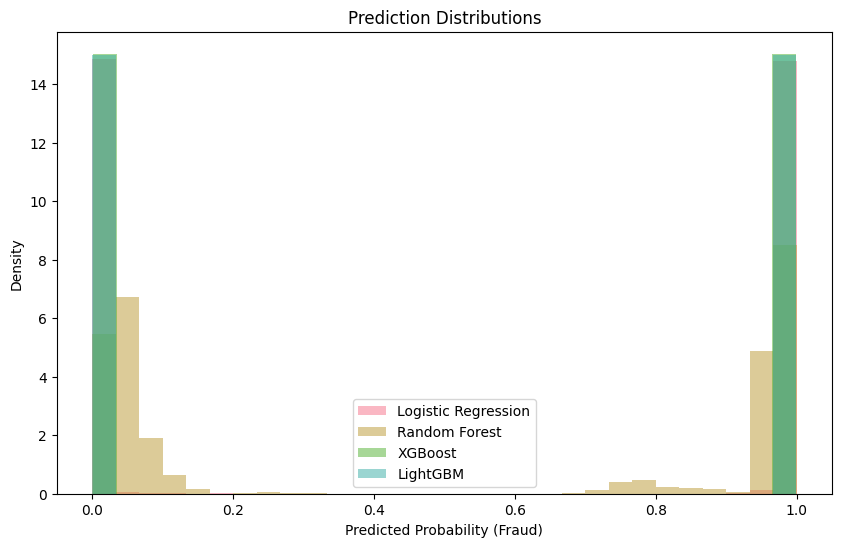

All models tested. Plots generated and saved.


In [21]:

categorical_cols = [
    'Transaction_Location', 'Card_Type', 'Transaction_Currency',
    'Transaction_Status', 'Authentication_Method', 'Transaction_Category'
]
numerical_cols = [
    'Transaction_Amount', 'Previous_Transaction_Count', 'Distance_Between_Transactions_km',
    'Time_Since_Last_Transaction_min', 'Transaction_Velocity', 'Transaction_Hour',
    'Transaction_Day', 'Transaction_Month', 'Log_Transaction_Amount',
    'Velocity_Distance_Interact', 'Amount_Velocity_Interact', 'Time_Distance_Interact',
    'Hour_sin', 'Hour_cos', 'Weekday_sin', 'Weekday_cos'
]

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)
    ],
    remainder='drop'  # Drop IDs and other unused columns
)

# Separate features and target
X = data.drop('isFraud', axis=1)
y = data['isFraud']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Now the training loop (as provided, but with preprocessor and splits available)
results = {}
best_pipelines = {}
model_times = []
pbar = tqdm(models.items(), total=len(models), desc="Training Models", unit="model")

for idx, (name, info) in enumerate(pbar):
    logger.info(f"Starting tuning for {name} ({idx+1}/{len(models)})")
    
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', info['model'])])
    
    search = RandomizedSearchCV(pipeline, info['params'], n_iter=20, cv=3, scoring='f1', 
                                random_state=42, n_jobs=-1, verbose=1)
    
    fit_start_time = time.time()
    search.fit(X_train, y_train)
    fit_end_time = time.time()
    fit_duration = fit_end_time - fit_start_time
    
    model_times.append(fit_duration)
    
    if model_times:
        avg_time = sum(model_times) / len(model_times)
        remaining_models = len(models) - (idx + 1)
        eta_seconds = avg_time * remaining_models
        eta_min = eta_seconds / 60
        pbar.set_postfix({
            'Time per model': f'{avg_time:.1f}s',
            'ETA remaining': f'{eta_min:.1f} min',
            'Progress': f'{((idx + 1) / len(models)) * 100:.1f}%'
        })
    
    best_pipeline = search.best_estimator_
    best_pipelines[name] = best_pipeline
    print(f'{name} Best Params: {search.best_params_}')
    
    y_pred = best_pipeline.predict(X_test)
    y_prob = best_pipeline.predict_proba(X_test)[:, 1] if hasattr(best_pipeline.named_steps['classifier'], 'predict_proba') else None
    
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    roc_auc = roc_auc_score(y_test, y_prob) if y_prob is not None else 'N/A'
    
    results[name] = {
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'ROC AUC': roc_auc
    }
    
    print(f'{name} Classification Report:\n{classification_report(y_test, y_pred, zero_division=0)}')

pbar.close()

results_df = pd.DataFrame(results).T
print(results_df)

# Plotting section (as provided, with additional plot types for "all types")
from sklearn.model_selection import learning_curve
import numpy as np

# 1. Model Comparison Bar Plot
results_df.plot(kind='bar', figsize=(12, 8))
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300)
plt.show()

# 2. Confusion Matrices for All Models
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()
for idx, (name, pipeline) in enumerate(best_pipelines.items()):
    y_pred = pipeline.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx])
    axes[idx].set_title(f'Confusion Matrix - {name}')
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('True')
plt.tight_layout()
plt.savefig('confusion_matrices_all.png', dpi=300)
plt.show()

# 3. ROC Curves
plt.figure(figsize=(10, 8))
for name, pipeline in best_pipelines.items():
    if hasattr(pipeline.named_steps['classifier'], 'predict_proba'):
        y_prob = pipeline.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC={roc_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curves')
plt.legend()
plt.savefig('roc_all.png', dpi=300)
plt.show()

# 4. Precision-Recall Curves
plt.figure(figsize=(10, 8))
for name, pipeline in best_pipelines.items():
    if hasattr(pipeline.named_steps['classifier'], 'predict_proba'):
        y_prob = pipeline.predict_proba(X_test)[:, 1]
        precision, recall, _ = precision_recall_curve(y_test, y_prob)
        pr_auc = auc(recall, precision)
        plt.plot(recall, precision, lw=2, label=f'{name} (PR-AUC={pr_auc:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR Curves')
plt.legend()
plt.savefig('pr_all.png', dpi=300)
plt.show()

# 5. Feature Importances (Tree Models)
tree_models = ['Random Forest', 'XGBoost', 'LightGBM']
for name in tree_models:
    if name in best_pipelines:
        pipeline = best_pipelines[name]
        if hasattr(pipeline.named_steps['classifier'], 'feature_importances_'):
            feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()
            importances = pipeline.named_steps['classifier'].feature_importances_
            top_idx = np.argsort(importances)[-10:]
            plt.figure(figsize=(10, 6))
            plt.barh(range(10), importances[top_idx])
            plt.yticks(range(10), feature_names[top_idx])
            plt.title(f'Top Features - {name}')
            plt.tight_layout()
            plt.savefig(f'features_{name}.png', dpi=300)
            plt.show()

# 6. Learning Curves
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.ravel()
for idx, (name, pipeline) in enumerate(best_pipelines.items()):
    train_sizes, train_scores, val_scores = learning_curve(
        pipeline, X_train, y_train, cv=3, scoring='f1', n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 5)
    )
    train_mean = np.mean(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    axes[idx].plot(train_sizes, train_mean, 'o-', label='Train')
    axes[idx].plot(train_sizes, val_mean, 'o-', label='Val')
    axes[idx].set_title(name)
    axes[idx].legend()
plt.tight_layout()
plt.savefig('learning_curves.png', dpi=300)
plt.show()

# 7. Residual Plots (Predictions vs Actual for Best Model)
best_model_name = results_df['F1 Score'].idxmax()
best_pipeline = best_pipelines[best_model_name]
y_pred_best = best_pipeline.predict(X_test)
plt.figure(figsize=(8, 6))
plt.scatter(range(len(y_test)), y_test - y_pred_best, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Sample Index')
plt.ylabel('Residual (True - Pred)')
plt.title(f'Residuals - {best_model_name}')
plt.savefig('residuals_best.png', dpi=300)
plt.show()

# 8. Prediction Distribution Histograms
plt.figure(figsize=(10, 6))
for name, pipeline in best_pipelines.items():
    if hasattr(pipeline.named_steps['classifier'], 'predict_proba'):
        y_prob = pipeline.predict_proba(X_test)[:, 1]
        plt.hist(y_prob, bins=30, alpha=0.5, label=name, density=True)
plt.xlabel('Predicted Probability (Fraud)')
plt.ylabel('Density')
plt.title('Prediction Distributions')
plt.legend()
plt.savefig('pred_dist_all.png', dpi=300)
plt.show()

print("All models tested. Plots generated and saved.")

### Neural Network With Tensorflow


In [7]:
!pip list --format=columns

Package                           Version
--------------------------------- --------------
absl-py                           2.3.0
accelerate                        1.10.1
aiofiles                          24.1.0
aiohappyeyeballs                  2.6.1
aiohttp                           3.12.15
aiosignal                         1.4.0
alembic                           1.16.5
altair                            5.5.0
annotated-types                   0.7.0
anyio                             4.9.0
argon2-cffi                       25.1.0
argon2-cffi-bindings              25.1.0
arrow                             1.3.0
asttokens                         3.0.0
astunparse                        1.6.3
async-lru                         2.0.5
async-timeout                     5.0.1
attrs                             25.3.0
babel                             2.17.0
beautifulsoup4                    4.14.2
bleach                            6.2.0
blinker                           1.9.0
branca             

In [9]:
import tensorflow as tf
print("TF Version:", tf.__version__)

AttributeError: module 'tensorflow' has no attribute '__version__'

In [7]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.model_selection import learning_curve
import numpy as np

# Preprocess data for NN (one-time)
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Convert to dense arrays if sparse
if hasattr(X_train_processed, 'toarray'):
    X_train_processed = X_train_processed.toarray()
    X_test_processed = X_test_processed.toarray()

input_dim = X_train_processed.shape[1]
logger.info(f"Processed input shape: {X_train_processed.shape}")

# Define and train Neural Network
nn_model = Sequential([
    Dense(128, activation='relu', input_shape=(input_dim,)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = nn_model.fit(
    X_train_processed, y_train,
    epochs=100,
    batch_size=256,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

# Evaluate NN
y_pred_nn = (nn_model.predict(X_test_processed) > 0.5).astype(int).flatten()
y_prob_nn = nn_model.predict(X_test_processed).flatten()

precision_nn = precision_score(y_test, y_pred_nn, zero_division=0)
recall_nn = recall_score(y_test, y_pred_nn, zero_division=0)
f1_nn = f1_score(y_test, y_pred_nn, zero_division=0)
roc_auc_nn = roc_auc_score(y_test, y_prob_nn)

results['Neural Network'] = {
    'Precision': precision_nn,
    'Recall': recall_nn,
    'F1 Score': f1_nn,
    'ROC AUC': roc_auc_nn
}

best_pipelines['Neural Network'] = nn_model  # Store model for plots

print('Neural Network Classification Report:\n', classification_report(y_test, y_pred_nn, zero_division=0))

# Update results_df
results_df = pd.DataFrame(results).T
print(results_df)

# Plots (updated to include NN where applicable)
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Bar Plot
results_df.plot(kind='bar', figsize=(12, 8))
plt.title('Model Performance Comparison (incl. NN)')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('model_comparison_nn.png', dpi=300)
plt.show()

# 2. Confusion Matrices (All, incl. NN)
fig, axes = plt.subplots(2, 3, figsize=(15, 10))  # Adjusted for 5 models
axes = axes.ravel()
model_names = list(best_pipelines.keys())
for idx, name in enumerate(model_names):
    if name == 'Neural Network':
        y_pred = y_pred_nn
        cm = confusion_matrix(y_test, y_pred)
    else:
        pipeline = best_pipelines[name]
        y_pred = pipeline.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx])
    axes[idx].set_title(f'Confusion Matrix - {name}')
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('True')
if len(model_names) < 6:
    axes[-1].remove()  # Hide empty subplot
plt.tight_layout()
plt.savefig('confusion_matrices_all_nn.png', dpi=300)
plt.show()

# 3. ROC Curves (All, incl. NN)
plt.figure(figsize=(10, 8))
for name in model_names:
    if name == 'Neural Network':
        y_prob = y_prob_nn
    else:
        pipeline = best_pipelines[name]
        if hasattr(pipeline.named_steps['classifier'], 'predict_proba'):
            y_prob = pipeline.predict_proba(X_test)[:, 1]
            fpr, tpr, _ = roc_curve(y_test, y_prob)
            roc_auc_val = auc(fpr, tpr)
            plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc_val:.3f})')
        continue
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc_val = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc_val:.3f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (incl. NN)')
plt.legend(loc="lower right")
plt.savefig('roc_curves_all_nn.png', dpi=300)
plt.show()

# 4. Precision-Recall Curves (All, incl. NN)
plt.figure(figsize=(10, 8))
for name in model_names:
    if name == 'Neural Network':
        y_prob = y_prob_nn
    else:
        pipeline = best_pipelines[name]
        if hasattr(pipeline.named_steps['classifier'], 'predict_proba'):
            y_prob = pipeline.predict_proba(X_test)[:, 1]
            precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_prob)
            pr_auc_val = auc(recall_vals, precision_vals)
            plt.plot(recall_vals, precision_vals, lw=2, label=f'{name} (AUC = {pr_auc_val:.3f})')
        continue
    precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_prob)
    pr_auc_val = auc(recall_vals, precision_vals)
    plt.plot(recall_vals, precision_vals, lw=2, label=f'{name} (AUC = {pr_auc_val:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR Curves (incl. NN)')
plt.legend(loc="lower left")
plt.savefig('pr_curves_all_nn.png', dpi=300)
plt.show()

# 5. Learning Curve for NN (using history)
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('NN Learning Curve')
plt.legend()
plt.savefig('nn_learning_curve.png', dpi=300)
plt.show()

# 6. Prediction Distributions (All, incl. NN)
plt.figure(figsize=(12, 8))
for name in model_names:
    if name == 'Neural Network':
        y_prob = y_prob_nn
    else:
        pipeline = best_pipelines[name]
        if hasattr(pipeline.named_steps['classifier'], 'predict_proba'):
            y_prob = pipeline.predict_proba(X_test)[:, 1]
        else:
            continue
    plt.hist(y_prob, bins=50, alpha=0.5, label=name, density=True)
plt.xlabel('Predicted Fraud Probability')
plt.ylabel('Density')
plt.title('Prediction Distributions (incl. NN)')
plt.legend()
plt.savefig('pred_distributions_all_nn.png', dpi=300)
plt.show()

print("NN trained and all plots generated/saved.")

ModuleNotFoundError: No module named 'tensorflow.keras'